In [1]:
from sims import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random



Approval Voting Simulation Results
Voters: 20, Candidates: 5, Dimensions: 10
Budget per candidate: 20.0, Voting vector sparsity: 0.4

Vote counts for each candidate:
  Candidate 1: 3 votes (15.0% approval rate)
  Candidate 2: 3 votes (15.0% approval rate)
  Candidate 3: 9 votes (45.0% approval rate)
  Candidate 4: 4 votes (20.0% approval rate)
  Candidate 5: 1 votes (5.0% approval rate)

Total votes cast: 20
Average approvals per voter: 1.00

Top 3 candidates (by vote count): [3, 4, 2]
Winner (randomly selected from top 3): Candidate 2
Global utility (using true utility vectors): 157.8211
Average utility per voter: 7.8911



INTERPRETATION GUIDE:

Between-Condition Variance (sensitivity to initial conditions):
  - HIGH: Optimization finds different local optima from different starts
  - LOW: Optimization converges to similar solutions regardless of starting point
  - This tells you how "rugged" the optimization landscape is

Within-Condition Variance (randomness in outcomes):
  - HIGH: Winner selection is very random, many different winners possible
  - LOW: Same candidates tend to win repeatedly
  - This tells you how predictable outcomes are given fixed candidates

Coefficient of Variation (CV):
  - CV < 5%: Very stable, initial conditions don't matter much
  - CV 5-15%: Moderate sensitivity
  - CV > 15%: High sensitivity, initial conditions matter a lot

Practical Implications:
  - High between-condition variance → Need to try multiple optimizations
  - Low between-condition variance → Single optimization is reliable
  - High within-condition variance → Outcomes are unpredictable
  - Low within-conditi

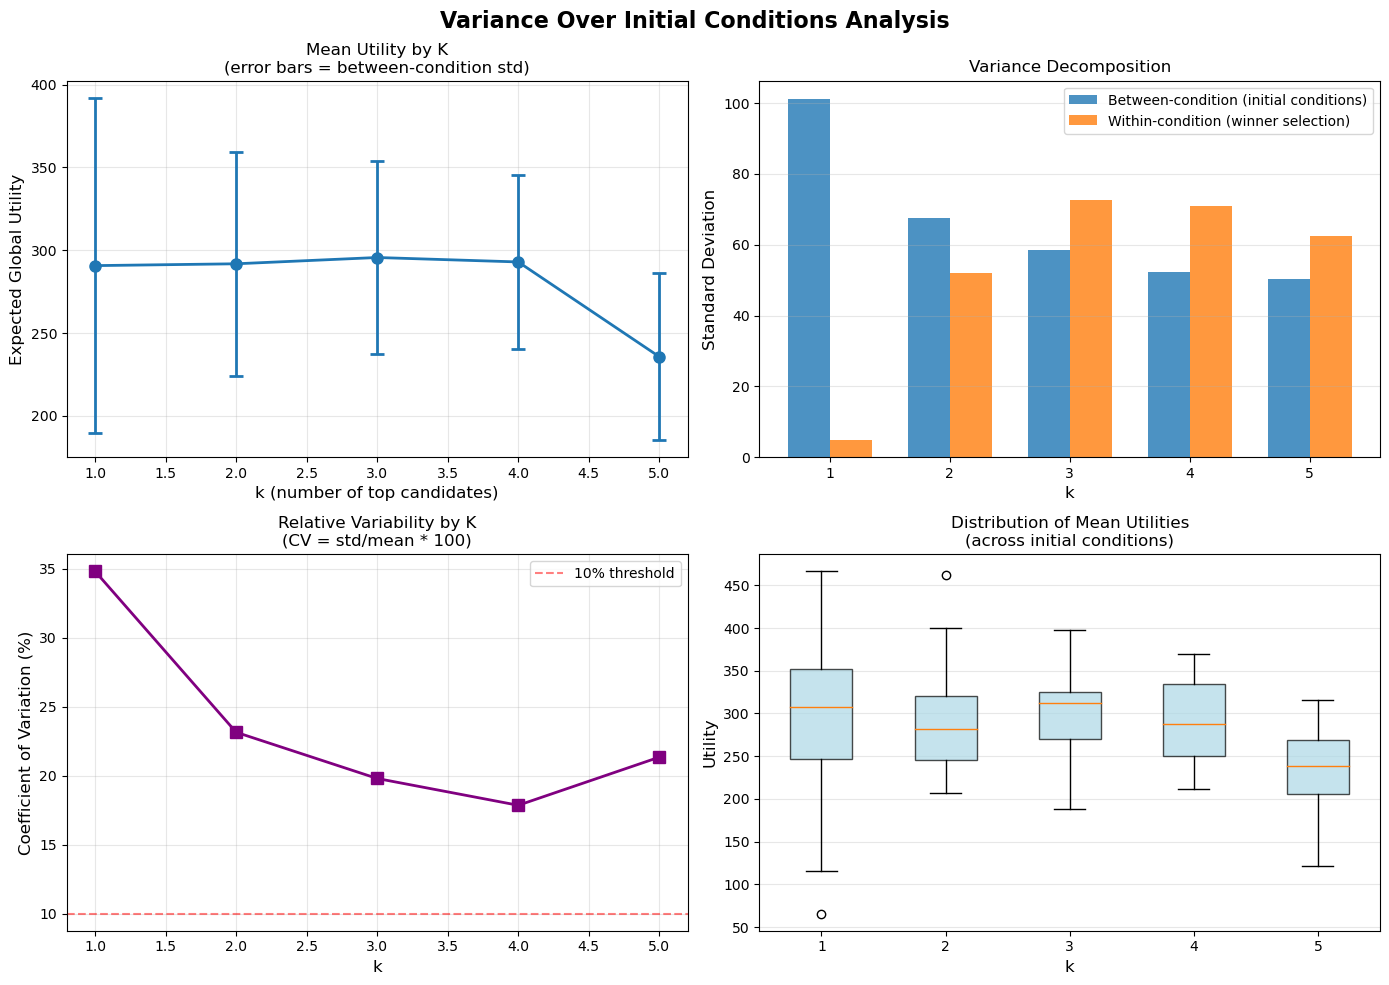

In [3]:
import numpy as np
import matplotlib.pyplot as plt

"""
Complete framework for testing variance over initial conditions.
This helps you understand:
1. How sensitive outcomes are to where candidates start
2. Whether optimization converges to similar or different equilibria
3. How this varies with k
"""

# ============================================================
# CORE FUNCTION: Run with Multiple Initial Conditions
# ============================================================

def test_variance_over_initial_conditions(
    voting_vectors, 
    true_utility_vectors, 
    n_candidates, 
    budget,
    k_values=None,
    n_initial_conditions=20,
    n_simulations_per_condition=100,
    learning_rate=0.05,
    convergence_threshold=1e-2,
    max_iterations=500,
    base_seed=42,
    verbose=True
):
    """
    Test how much outcomes vary based on initial candidate positions.
    
    For each k:
      - Run optimization from N different random starting positions
      - For each optimized set of candidates, run simulations
      - Measure variance ACROSS different initial conditions
    
    Parameters:
    -----------
    voting_vectors : array-like, shape (n_voters, d)
        Voting vectors
    true_utility_vectors : array-like, shape (n_voters, d)
        True utility vectors
    n_candidates : int
        Number of candidates
    budget : float
        Budget constraint
    k_values : list of int, optional
        Which k values to test (default: all from 1 to n_candidates)
    n_initial_conditions : int, default=20
        Number of different starting positions to try
    n_simulations_per_condition : int, default=100
        Number of voting simulations per optimized candidate set
    learning_rate : float
        Learning rate for optimization
    convergence_threshold : float
        Convergence threshold
    max_iterations : int
        Max optimization iterations
    base_seed : int
        Base random seed
    verbose : bool
        Print progress
    
    Returns:
    --------
    results : dict
        Comprehensive results including:
        - Mean utility by k
        - Within-condition variance (randomness in winner selection)
        - Between-condition variance (sensitivity to initial positions)
        - All raw data for further analysis
    """
    voting_vectors = np.asarray(voting_vectors)
    true_utility_vectors = np.asarray(true_utility_vectors)
    n_voters, d_dimensions = voting_vectors.shape
    
    if k_values is None:
        k_values = list(range(1, n_candidates + 1))
    
    if verbose:
        print("=" * 80)
        print("VARIANCE OVER INITIAL CONDITIONS ANALYSIS")
        print("=" * 80)
        print(f"Voters: {n_voters}, Candidates: {n_candidates}, Dimensions: {d_dimensions}")
        print(f"Budget: {budget}")
        print(f"Testing {len(k_values)} k values with {n_initial_conditions} initial conditions each")
        print(f"Simulations per condition: {n_simulations_per_condition}")
        print("=" * 80)
        print()
    
    results = {
        'k_values': k_values,
        'by_k': {}
    }
    
    for k in k_values:
        if verbose:
            print(f"\n{'=' * 80}")
            print(f"K = {k}")
            print(f"{'=' * 80}")
        
        # Store results for this k across all initial conditions
        utilities_by_initial_condition = []
        optimized_candidates_by_condition = []
        convergence_info = []
        
        # Try different initial conditions
        for ic in range(n_initial_conditions):
            if verbose and ic % 5 == 0:
                print(f"  Initial condition {ic+1}/{n_initial_conditions}...", end='')
            
            # Different seed for this initial condition
            ic_seed = base_seed + ic * 1000 + k * 100
            np.random.seed(ic_seed)
            
            # Generate random initial candidates
            initial_candidates = generate_candidates(
                n_candidates, d_dimensions, budget, seed=ic_seed
            )
            
            # Optimize from this starting point
            optimized_candidates, history = optimize_candidates(
                initial_candidates,
                voting_vectors,
                budget,
                k=k,
                learning_rate=learning_rate,
                convergence_threshold=convergence_threshold,
                max_iterations=max_iterations,
                seed=ic_seed,
                verbose=False
            )
            
            optimized_candidates_by_condition.append(optimized_candidates)
            convergence_info.append({
                'iterations': len(history),
                'converged': len(history) < max_iterations
            })
            
            # Run simulations with these optimized candidates
            utilities_this_condition = []
            
            for sim in range(n_simulations_per_condition):
                # Probabilistic voting
                approval_matrix = np.zeros((n_voters, n_candidates), dtype=bool)
                voting_vectors_list = [voting_vectors[i] for i in range(n_voters)]
                candidate_vectors_list = [optimized_candidates[i] for i in range(n_candidates)]
                
                for voter_idx in range(n_voters):
                    for candidate_idx in range(n_candidates):
                        prob = voting_probability(
                            voting_vectors_list,
                            voter_index=voter_idx,
                            candidate_list=candidate_vectors_list,
                            candidate_index=candidate_idx,
                            default=False
                        )
                        approval = np.random.rand() < prob
                        approval_matrix[voter_idx, candidate_idx] = approval
                
                vote_counts = np.sum(approval_matrix, axis=0)
                sorted_indices = np.argsort(vote_counts)[::-1]
                top_k_indices = sorted_indices[:k]
                
                # FIXED: Randomly select ONE winner (not average)
                winner_idx = np.random.choice(top_k_indices)
                
                # Compute actual utility for this winner
                winner_vector = optimized_candidates[winner_idx]
                global_utility = 0.0
                
                for voter_idx in range(n_voters):
                    true_utility_vector = true_utility_vectors[voter_idx]
                    voter_utility = utility_function(winner_vector, true_utility_vector)
                    global_utility += voter_utility
                
                utilities_this_condition.append(global_utility)
            
            # Store mean utility for this initial condition
            mean_utility_this_condition = np.mean(utilities_this_condition)
            utilities_by_initial_condition.append({
                'mean': mean_utility_this_condition,
                'std_within': np.std(utilities_this_condition),
                'all_values': utilities_this_condition
            })
            
            if verbose and ic % 5 == 0:
                print(f" mean utility = {mean_utility_this_condition:.2f}")
        
        # Analyze variance for this k
        mean_utilities = [u['mean'] for u in utilities_by_initial_condition]
        within_condition_stds = [u['std_within'] for u in utilities_by_initial_condition]
        
        results['by_k'][k] = {
            # Overall statistics
            'grand_mean': np.mean(mean_utilities),
            'between_condition_std': np.std(mean_utilities),  # Variance across initial conditions
            'mean_within_condition_std': np.mean(within_condition_stds),  # Avg variance within conditions
            
            # Raw data
            'mean_utilities': mean_utilities,
            'within_condition_stds': within_condition_stds,
            'utilities_by_initial_condition': utilities_by_initial_condition,
            'optimized_candidates': optimized_candidates_by_condition,
            'convergence_info': convergence_info,
            
            # Analysis
            'min_utility': np.min(mean_utilities),
            'max_utility': np.max(mean_utilities),
            'range': np.max(mean_utilities) - np.min(mean_utilities),
            'cv': np.std(mean_utilities) / np.mean(mean_utilities) * 100  # Coefficient of variation
        }
        
        if verbose:
            print(f"\n  Results for k={k}:")
            print(f"    Grand mean utility: {results['by_k'][k]['grand_mean']:.4f}")
            print(f"    Between-condition std: {results['by_k'][k]['between_condition_std']:.4f}")
            print(f"    Within-condition std (avg): {results['by_k'][k]['mean_within_condition_std']:.4f}")
            print(f"    Range: [{results['by_k'][k]['min_utility']:.4f}, "
                  f"{results['by_k'][k]['max_utility']:.4f}]")
            print(f"    Coefficient of variation: {results['by_k'][k]['cv']:.2f}%")
            
            # Count convergence
            n_converged = sum(1 for c in convergence_info if c['converged'])
            print(f"    Converged: {n_converged}/{n_initial_conditions}")
    
    return results


# ============================================================
# VISUALIZATION FUNCTIONS
# ============================================================

def plot_variance_analysis(results, save_path=None):
    """
    Create comprehensive visualizations of variance analysis.
    """
    k_values = results['k_values']
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Variance Over Initial Conditions Analysis', fontsize=16, fontweight='bold')
    
    # Extract data
    grand_means = [results['by_k'][k]['grand_mean'] for k in k_values]
    between_stds = [results['by_k'][k]['between_condition_std'] for k in k_values]
    within_stds = [results['by_k'][k]['mean_within_condition_std'] for k in k_values]
    cvs = [results['by_k'][k]['cv'] for k in k_values]
    
    # Plot 1: Mean utility by k with error bars
    ax1 = axes[0, 0]
    ax1.errorbar(k_values, grand_means, yerr=between_stds, 
                 marker='o', capsize=5, capthick=2, linewidth=2, markersize=8)
    ax1.set_xlabel('k (number of top candidates)', fontsize=12)
    ax1.set_ylabel('Expected Global Utility', fontsize=12)
    ax1.set_title('Mean Utility by K\n(error bars = between-condition std)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Variance decomposition
    ax2 = axes[0, 1]
    width = 0.35
    x = np.arange(len(k_values))
    ax2.bar(x - width/2, between_stds, width, label='Between-condition (initial conditions)', alpha=0.8)
    ax2.bar(x + width/2, within_stds, width, label='Within-condition (winner selection)', alpha=0.8)
    ax2.set_xlabel('k', fontsize=12)
    ax2.set_ylabel('Standard Deviation', fontsize=12)
    ax2.set_title('Variance Decomposition', fontsize=12)
    ax2.set_xticks(x)
    ax2.set_xticklabels(k_values)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Plot 3: Coefficient of variation
    ax3 = axes[1, 0]
    ax3.plot(k_values, cvs, marker='s', linewidth=2, markersize=8, color='purple')
    ax3.set_xlabel('k', fontsize=12)
    ax3.set_ylabel('Coefficient of Variation (%)', fontsize=12)
    ax3.set_title('Relative Variability by K\n(CV = std/mean * 100)', fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=10, color='r', linestyle='--', alpha=0.5, label='10% threshold')
    ax3.legend()
    
    # Plot 4: Distribution of utilities for each k
    ax4 = axes[1, 1]
    box_data = [results['by_k'][k]['mean_utilities'] for k in k_values]
    bp = ax4.boxplot(box_data, labels=k_values, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    ax4.set_xlabel('k', fontsize=12)
    ax4.set_ylabel('Utility', fontsize=12)
    ax4.set_title('Distribution of Mean Utilities\n(across initial conditions)', fontsize=12)
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    plt.show()


def print_detailed_analysis(results):
    """
    Print detailed statistical analysis.
    """
    print("\n" + "=" * 80)
    print("DETAILED VARIANCE ANALYSIS")
    print("=" * 80)
    
    k_values = results['k_values']
    
    # Summary table
    print("\nSummary Table:")
    print("-" * 80)
    print(f"{'k':<5} {'Mean':<12} {'Between-Std':<15} {'Within-Std':<15} {'CV%':<10} {'Range':<15}")
    print("-" * 80)
    
    for k in k_values:
        data = results['by_k'][k]
        print(f"{k:<5} {data['grand_mean']:<12.4f} {data['between_condition_std']:<15.4f} "
              f"{data['mean_within_condition_std']:<15.4f} {data['cv']:<10.2f} "
              f"{data['range']:<15.4f}")
    
    print("-" * 80)
    
    # Key insights
    print("\nKey Insights:")
    print("-" * 80)
    
    # Find k with highest sensitivity to initial conditions
    max_between_k = max(k_values, key=lambda k: results['by_k'][k]['between_condition_std'])
    print(f"1. Most sensitive to initial conditions: k={max_between_k}")
    print(f"   Between-condition std: {results['by_k'][max_between_k]['between_condition_std']:.4f}")
    
    # Find k with most stable outcomes
    min_between_k = min(k_values, key=lambda k: results['by_k'][k]['between_condition_std'])
    print(f"\n2. Most stable across initial conditions: k={min_between_k}")
    print(f"   Between-condition std: {results['by_k'][min_between_k]['between_condition_std']:.4f}")
    
    # Compare variance sources
    print("\n3. Variance decomposition:")
    for k in k_values:
        between = results['by_k'][k]['between_condition_std']
        within = results['by_k'][k]['mean_within_condition_std']
        total_var = between**2 + within**2
        between_pct = (between**2 / total_var * 100) if total_var > 0 else 0
        within_pct = (within**2 / total_var * 100) if total_var > 0 else 0
        print(f"   k={k}: {between_pct:.1f}% from initial conditions, "
              f"{within_pct:.1f}% from winner selection")
    
    # Optimal k
    optimal_k = max(k_values, key=lambda k: results['by_k'][k]['grand_mean'])
    print(f"\n4. Optimal k (highest mean utility): k={optimal_k}")
    print(f"   Mean utility: {results['by_k'][optimal_k]['grand_mean']:.4f}")
    
    print("\n" + "=" * 80)


# ============================================================
# EXAMPLE USAGE
# ============================================================

def run_example():
    """
    Complete example showing how to use the variance analysis.
    """
    print("EXAMPLE: Testing Variance Over Initial Conditions")
    print("=" * 80)
    print()
    
    # Generate test data
    n_voters = 40
    n_candidates = 5
    d_dimensions = 8
    budget = 10.0
    sparsity = 0.3
    
    print("Generating clustered voters...")
    true_utility_vectors, voting_vectors, cluster_labels = generate_clustered_voters(
        n=n_voters,
        d=d_dimensions,
        n_clusters=3,
        cluster_size_variance=0.2,
        sparsity=sparsity,
        seed=123
    )
    
    print(f"Generated {n_voters} voters in 3 clusters")
    print(f"Cluster sizes: {[np.sum(cluster_labels == i) for i in range(3)]}")
    print()
    
    # Run variance analysis
    results = test_variance_over_initial_conditions(
        voting_vectors=voting_vectors,
        true_utility_vectors=true_utility_vectors,
        n_candidates=n_candidates,
        budget=budget,
        k_values=[1, 2, 3, 4, 5],  # Test all k values
        n_initial_conditions=15,  # Try 15 different starting positions
        n_simulations_per_condition=50,  # 50 sims per starting position
        learning_rate=0.05,
        convergence_threshold=1e-2,
        max_iterations=200,
        base_seed=42,
        verbose=True
    )
    
    # Print detailed analysis
    print_detailed_analysis(results)
    
    # Create visualizations
    print("\nGenerating plots...")
    plot_variance_analysis(results, save_path='variance_analysis.png')
    
    return results


# ============================================================
# INTERPRETATION GUIDE
# ============================================================

print("""
INTERPRETATION GUIDE:
====================

Between-Condition Variance (sensitivity to initial conditions):
  - HIGH: Optimization finds different local optima from different starts
  - LOW: Optimization converges to similar solutions regardless of starting point
  - This tells you how "rugged" the optimization landscape is

Within-Condition Variance (randomness in outcomes):
  - HIGH: Winner selection is very random, many different winners possible
  - LOW: Same candidates tend to win repeatedly
  - This tells you how predictable outcomes are given fixed candidates

Coefficient of Variation (CV):
  - CV < 5%: Very stable, initial conditions don't matter much
  - CV 5-15%: Moderate sensitivity
  - CV > 15%: High sensitivity, initial conditions matter a lot

Practical Implications:
  - High between-condition variance → Need to try multiple optimizations
  - Low between-condition variance → Single optimization is reliable
  - High within-condition variance → Outcomes are unpredictable
  - Low within-condition variance → Outcomes are stable/predictable
""")

# Uncomment to run example:
results = run_example()